# Clasificación Automatica de Tickets con NLP

### Integrantes
* Raúl Molina Brito
* Omar Alavi Tambo

## Descripción del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trabajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [1]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [4]:
file_path = '/content/complaints.json'

# Open the JSON file in read mode
with open(file_path, 'r') as f:
    # Load the JSON data into a dictionary
    data = json.load(f)

# Convert the JSON data into a Pandas DataFrame
df = pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df_original=df.copy
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
 # print the column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [7]:
from prettytable import PrettyTable

# muestra una descripcion completa del datafame con el tipo de dato de la columna, cantidad de valores nulos y valores únicos
def informacion_df(df):
    print(f'Numero de filas:  {df.shape[0]}')
    print(f'Numero de columnas:  {df.shape[1]}')
    x = PrettyTable()
    x.field_names = ["Columnas", "Valores unicos", "Valores Nulos", "Tipo de Dato", "Valores"]
    for col in df.columns:
        x.add_row([col, len(df[col].unique()), df[col].isnull().sum(), df[col].dtype, df[col].unique()[0:3]])
    x.sortby = "Tipo de Dato"
    print(x)


# muestra información de las columnas con valores nulos
def mostrar_columnas_con_nulos(df):
    # Calcular el total de registros en el DataFrame
    total_registros = len(df)

    # Calcular el número de valores nulos en cada columna
    nulos_por_columna = df.isnull().sum()

    # Calcular el porcentaje de valores nulos en relación con el total de registros
    porcentaje_nulos_por_columna = (nulos_por_columna / total_registros) * 100

    # Obtener los tipos de dato de cada columna
    tipos_de_dato_por_columna = df.dtypes


    # Crear un DataFrame con las columnas y sus porcentajes de valores nulos
    info_columnas_nulos = pd.DataFrame({
        'Columna': nulos_por_columna.index,
        'Valores Nulos': nulos_por_columna.values,
        'Porcentaje Nulos': porcentaje_nulos_por_columna.values,
        'Tipo de Dato': tipos_de_dato_por_columna.values
    })

    # Filtrar las columnas que tienen valores nulos
    columnas_con_nulos = info_columnas_nulos[info_columnas_nulos['Valores Nulos'] > 0]

    # Imprimir las columnas con valores nulos y sus porcentajes
    print("Columnas con valores nulos:")
    print(columnas_con_nulos)

#
def eliminar_columnas_con_nulos(df, umbral=0.5):
    """
    Elimina las columnas con un porcentaje de valores nulos superior al umbral especificado.

    :param df: DataFrame de pandas.
    :param umbral: Umbral de porcentaje de valores nulos (valor entre 0 y 1).
    :return: DataFrame sin las columnas eliminadas.
    """
    # Calcular el número máximo de valores nulos permitidos en una columna
    num_max_nulos = len(df) * umbral

    # Identificar las columnas que cumplen con el umbral de valores nulos
    columnas_a_eliminar = df.columns[df.isna().sum() > num_max_nulos]

    # Eliminar las columnas que cumplen con el umbral de valores nulos
    df_sin_columnas_nulas = df.drop(columns=columnas_a_eliminar)

    return df_sin_columnas_nulas


Renombramos los nombres de la columnas

In [8]:
df.columns = df.columns.str.replace('_source.', '')

In [9]:
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

Verficamos que columnas tienen valores nulos

In [10]:
mostrar_columnas_con_nulos(df)

Columnas con valores nulos:
                      Columna  Valores Nulos  Porcentaje Nulos Tipo de Dato
4                        tags          67413         86.081493       object
5                    zip_code           6757          8.628197       object
9                       state           1991          2.542362       object
16    company_public_response          78309         99.994892       object
17                sub_product          10571         13.498397       object
20                  sub_issue          46297         59.117899       object
21  consumer_consent_provided           1008          1.287143       object


In [11]:
informacion_df(df)

Numero de filas:  78313
Numero de columnas:  22
+---------------------------+----------------+---------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|          Columnas         | Valores unicos | Valores Nulos | Tipo de Dato |                                                                                                                                                                                                                                                    Valores                                                  

Eliminamos las columnas que tienen un unico valor

In [12]:
df=df.drop(columns=['_score','_index','_type','company'])

Eliminamos las columnas que son identificadores del registro

In [13]:
df=df.drop(columns=['_id', 'complaint_id'])

Eliminamos las columnas con mas del 50% de nulos

In [14]:
df.sub_issue.value_counts()

Credit card company isn't resolving a dispute about a purchase on your statement    2904
Deposits and withdrawals                                                            2759
Company closed your account                                                         2020
Problem using a debit or ATM card                                                   1613
Card was charged for something you did not purchase with the card                   1056
                                                                                    ... 
Problem with additional add-on products or services purchased with the loan            1
Receiving unwanted marketing/advertising                                               1
Report shared with employer w/o consent                                                1
Problem cancelling or closing account                                                  1
Account terms and changes                                                              1
Name: sub_issue, Leng

In [15]:
df=eliminar_columnas_con_nulos(df,0.5)

In [16]:
informacion_df(df)

Numero de filas:  78313
Numero de columnas:  13
+---------------------------+----------------+---------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|          Columnas         | Valores unicos | Valores Nulos | Tipo de Dato |                                                                                                                                                                                                                                                    Valores                                                  

In [17]:
df['product'].value_counts()

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [18]:
df['issue'].value_counts()

Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Name: issue, Length: 154, dtype:

Eliminamos los registros que tienen valores nulos

In [19]:
#Remove all rows where complaints column is nan
df = df.dropna()

In [20]:
df

,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_consent_provided
0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided
1,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided
2,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided
3,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided
4,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78306,11217,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,Referral,2018-12-18T12:00:00-05:00,Checking account,Yes,,N/A
78307,074XX,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,Web,2019-02-19T12:00:00-05:00,Conventional home mortgage,Yes,,Other
78308,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided
78309,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided


In [21]:
df[['complaint_what_happened','product','sub_product','issue']].iloc[1]

complaint_what_happened    Good morning my name is XXXX XXXX and I apprec...
product                                                      Debt collection
sub_product                                                 Credit card debt
issue                                        Written notification about debt
Name: 1, dtype: object

In [22]:
df[['complaint_what_happened']].iloc[1]

complaint_what_happened    Good morning my name is XXXX XXXX and I apprec...
Name: 1, dtype: object

In [23]:
informacion_df(df)

Numero de filas:  60731
Numero de columnas:  13
+---------------------------+----------------+---------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|          Columnas         | Valores unicos | Valores Nulos | Tipo de Dato |                                                                                                                                                                                                                                                    Valores                                                  

In [24]:
df

,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_consent_provided
0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided
1,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided
2,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided
3,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided
4,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78306,11217,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,Referral,2018-12-18T12:00:00-05:00,Checking account,Yes,,N/A
78307,074XX,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,Web,2019-02-19T12:00:00-05:00,Conventional home mortgage,Yes,,Other
78308,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided
78309,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided


## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [25]:
# Write your function to Lemmatize the texts
# Función para lematizar el texto
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text


In [26]:
# Definir una función para realizar la limpieza y el procesamiento
# - Make the text lowercase
# - Remove text in square brackets
# - Remove punctuation
# - Remove words containing numbers

def preprocess_text(text):
    # Eliminar caracteres dentro de corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Convertir el texto a minúsculas
    text = text.lower()

    # Eliminar puntuación
    text = re.sub(f"[{string.punctuation}]", '', text)

    # Eliminar palabras que contienen números
    text = ' '.join([word for word in text.split() if not any(char.isdigit() for char in word)])

    return text


# Función para extraer sustantivos (NN) del texto
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return ' '.join(nouns)

In [27]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
# Limpiamos la columna quejas
df['cleaned_text'] = df['complaint_what_happened'].apply(preprocess_text)

In [28]:
df

,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_consent_provided,cleaned_text
0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided,
1,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided,i upgraded my xxxx xxxx card in and was told b...
3,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided,
4,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78306,11217,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,Referral,2018-12-18T12:00:00-05:00,Checking account,Yes,,N/A,
78307,074XX,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,Web,2019-02-19T12:00:00-05:00,Conventional home mortgage,Yes,,Other,
78308,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided,
78309,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided,on wednesday xxxxxxxx i called chas my xxxx xx...


In [29]:
# Cargar el modelo de spaCy en inglés
nlp = spacy.load('en_core_web_sm')


In [30]:
# Aplicar la lematización a la Columna de Quejas df['complaint_what_happened']
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)


In [31]:
df

,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_consent_provided,cleaned_text,lemmatized_text
0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided,,
1,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
3,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided,,
4,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78306,11217,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,Referral,2018-12-18T12:00:00-05:00,Checking account,Yes,,N/A,,
78307,074XX,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,Web,2019-02-19T12:00:00-05:00,Conventional home mortgage,Yes,,Other,,
78308,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided,,
78309,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...


In [32]:
#Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].
df['Complaint_text'] = df['lemmatized_text'].apply(extract_nouns)


In [33]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df

,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,sub_product,timely,complaint_what_happened,consumer_consent_provided,cleaned_text,lemmatized_text,Complaint_text
0,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,Credit card debt,Yes,,Consent not provided,,,
1,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,77069,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,Web,2019-04-02T12:00:00-05:00,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Consent provided,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...
3,48066,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,Web,2017-09-14T12:00:00-05:00,Conventional home mortgage,Yes,,Consent not provided,,,
4,10473,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,Referral,2019-04-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,,N/A,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78306,11217,Managing an account,2018-12-12T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,Referral,2018-12-18T12:00:00-05:00,Checking account,Yes,,N/A,,,
78307,074XX,Applying for a mortgage or refinancing an exis...,2019-02-19T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,Web,2019-02-19T12:00:00-05:00,Conventional home mortgage,Yes,,Other,,,
78308,08857,Closing an account,2018-12-20T12:00:00-05:00,NJ,N/A,Checking or savings account,Closed with explanation,Web,2018-12-21T12:00:00-05:00,Checking account,Yes,,Consent not provided,,,
78309,934XX,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,N/A,Credit card or prepaid card,Closed with monetary relief,Web,2018-12-05T12:00:00-05:00,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Consent provided,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

In [34]:
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams


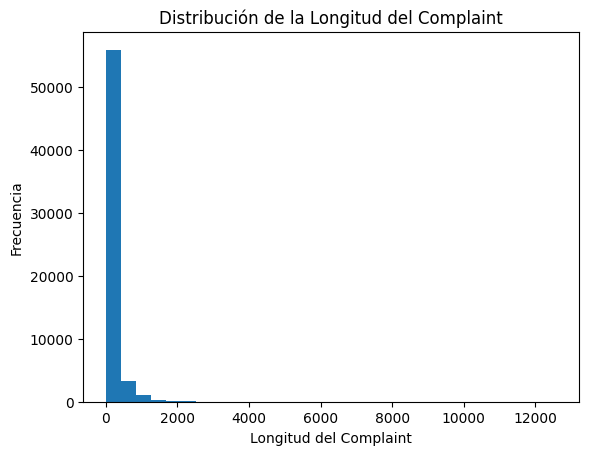

In [35]:
# Write your code here to visualise the data according to the 'Complaint' character length
# Visualiza los datos según la longitud de 'Complaint'
df['Complaint_Length'] = df['Complaint_text'].apply(len)
plt.hist(df['Complaint_Length'], bins=30)
plt.xlabel('Longitud del Complaint')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Longitud del Complaint')
plt.show()

In [36]:
# Procesar el texto de las quejas
stop_words = set(stopwords.words('english'))  # Puedes cambiar 'english' al idioma que estés utilizando
text = ' '.join(df['Complaint_text'])
tokens = word_tokenize(text)
filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]


#### Find the top 40 words by frequency among all the articles after processing the text.

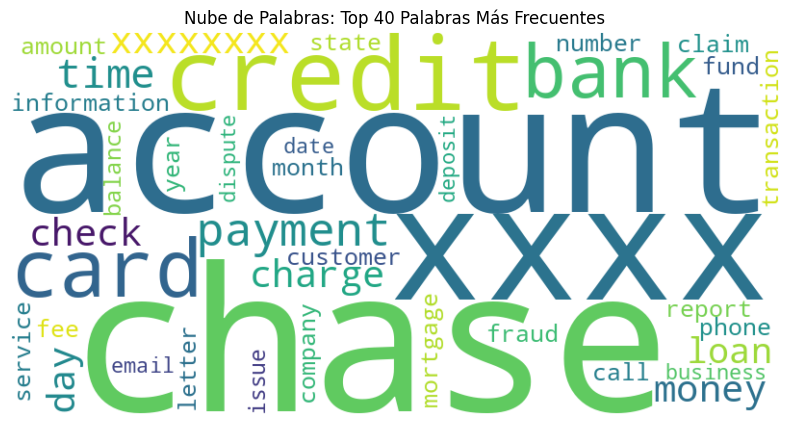

In [37]:
# Crear una nube de palabras con las 40 palabras más frecuentes
word_freq = Counter(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Top 40 Palabras Más Frecuentes')
plt.show()

In [38]:
#Removing -PRON- from the text corpus
df_clean = pd.DataFrame()
df_clean['Complaint_clean'] = df['Complaint_text'].str.replace('-PRON-', '')

In [39]:
df_clean

,Complaint_clean
0,
1,morning name stop bank cardmember service ask ...
2,xxxx agent anniversary date agent information ...
3,
4,
...,...
78306,
78307,
78308,
78309,xxxx credit card provider claim purchase prote...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [40]:
df_aux = pd.DataFrame()

In [41]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk import FreqDist

# Assuming df_clean is your DataFrame with a 'cleaned_complaints' column
# Replace 'cleaned_complaints' with the actual column name if needed.


# Tokenize the complaints text into words (unigrams)
df_aux['Complaint_clean_uni'] = df_clean['Complaint_clean'].apply(nltk.word_tokenize)

# Flatten the list of tokenized words
all_words = [word for sublist in df_aux['Complaint_clean_uni'] for word in sublist]

# Calculate the frequency distribution of unigrams
fdist = FreqDist(all_words)

# Get the top 30 unigrams
top_30_unigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_unigrams_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

# Print the top 30 unigrams
print(top_30_unigrams_df)


        Unigram  Frequency
0         chase      36405
1       account      34646
2          xxxx      28274
3        credit      21341
4          card      19207
5          bank      15939
6       payment      14414
7          time      11535
8           day       9473
9        charge       9447
10        money       9261
11        check       9129
12     xxxxxxxx       9115
13         loan       8271
14  information       6813
15       letter       6637
16  transaction       6435
17       report       6330
18       number       6272
19          fee       6176
20       amount       5988
21         call       5965
22     mortgage       5938
23         year       5843
24     customer       5767
25        month       5693
26        claim       5678
27         fund       5530
28        phone       5412
29      service       5242


In [42]:
df_aux

,Complaint_clean_uni
0,[]
1,"[morning, name, stop, bank, cardmember, servic..."
2,"[xxxx, agent, anniversary, date, agent, inform..."
3,[]
4,[]
...,...
78306,[]
78307,[]
78308,[]
78309,"[xxxx, credit, card, provider, claim, purchase..."


In [43]:
#Print the top 10 words in the unigram frequency
# Encontrar los mejores unigramas, bigramas y trigramas por frecuencia
# Get the top 10 unigrams
top_10_unigrams = fdist.most_common(10)

# Create a DataFrame to display the results
top_10_unigrams_df = pd.DataFrame(top_10_unigrams, columns=['Unigram', 'Frequency'])

# Print the top 10 unigrams
print(top_10_unigrams_df)

   Unigram  Frequency
0    chase      36405
1  account      34646
2     xxxx      28274
3   credit      21341
4     card      19207
5     bank      15939
6  payment      14414
7     time      11535
8      day       9473
9   charge       9447


In [44]:
from nltk.util import ngrams

# Assuming df_clean is your DataFrame with a 'cleaned_complaints' column
# Replace 'cleaned_complaints' with the actual column name if needed.

# Tokenize the complaints text into words
df_aux['Complaint_clean_bi'] = df_clean['Complaint_clean'].apply(nltk.word_tokenize)

# Function to generate bigrams
def generate_bigrams(tokens):
    return list(ngrams(tokens, 2))

# Apply the function to create bigrams from tokenized words
df_aux['bigrams'] = df_aux['Complaint_clean_bi'].apply(generate_bigrams)

# Flatten the list of bigrams
all_bigrams = [bigram for sublist in df_aux['bigrams'] for bigram in sublist]

# Calculate the frequency distribution of bigrams
fdist = FreqDist(all_bigrams)

# Get the top 30 bigrams
top_30_bigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_bigrams_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

# Print the top 30 bigrams
print(top_30_bigrams_df)

                 Bigram  Frequency
0        (credit, card)       7599
1      (credit, report)       2726
2          (xxxx, xxxx)       2323
3   (customer, service)       2179
4      (account, chase)       2088
5      (chase, account)       1825
6       (bank, account)       1802
7      (check, account)       1694
8       (chase, credit)       1687
9    (account, account)       1647
10        (debit, card)       1630
11        (chase, bank)       1527
12  (checking, account)       1480
13        (phone, call)       1153
14       (number, xxxx)       1117
15      (credit, score)       1114
16      (account, xxxx)       1070
17        (chase, card)       1065
18      (card, account)       1055
19     (money, account)       1025
20      (business, day)        966
21    (account, credit)        956
22      (account, bank)        940
23      (phone, number)        935
24        (card, chase)        929
25      (xxxx, account)        914
26        (xxxx, chase)        909
27       (xxxx, cred

In [45]:
df_aux

,Complaint_clean_uni,Complaint_clean_bi,bigrams
0,[],[],[]
1,"[morning, name, stop, bank, cardmember, servic...","[morning, name, stop, bank, cardmember, servic...","[(morning, name), (name, stop), (stop, bank), ..."
2,"[xxxx, agent, anniversary, date, agent, inform...","[xxxx, agent, anniversary, date, agent, inform...","[(xxxx, agent), (agent, anniversary), (anniver..."
3,[],[],[]
4,[],[],[]
...,...,...,...
78306,[],[],[]
78307,[],[],[]
78308,[],[],[]
78309,"[xxxx, credit, card, provider, claim, purchase...","[xxxx, credit, card, provider, claim, purchase...","[(xxxx, credit), (credit, card), (card, provid..."


In [46]:
#Print the top 10 words in the bigram frequency
# Get the top 10 bigrams
top_10_bigrams = fdist.most_common(10)

# Create a DataFrame to display the results
top_10_bigrams_df = pd.DataFrame(top_10_bigrams, columns=['Bigram', 'Frequency'])

# Print the top 10 bigrams
print(top_10_bigrams_df)

                Bigram  Frequency
0       (credit, card)       7599
1     (credit, report)       2726
2         (xxxx, xxxx)       2323
3  (customer, service)       2179
4     (account, chase)       2088
5     (chase, account)       1825
6      (bank, account)       1802
7     (check, account)       1694
8      (chase, credit)       1687
9   (account, account)       1647


In [47]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
# Tokenize the complaints text into words
df_aux['Complaint_clean_tri'] = df_clean['Complaint_clean'].apply(nltk.word_tokenize)

# Function to generate trigrams
def generate_trigrams(tokens):
    return list(ngrams(tokens, 3))

# Apply the function to create bigrams from tokenized words
df_aux['trigrams'] = df_aux['Complaint_clean_tri'].apply(generate_trigrams)

# Flatten the list of trigrams
all_trigrams = [trigram for sublist in df_aux['trigrams'] for trigram in sublist]

# Calculate the frequency distribution of trigrams
fdist = FreqDist(all_trigrams)

# Get the top 30 trigrams
top_30_trigrams = fdist.most_common(30)

# Create a DataFrame to display the results
top_30_trigrams_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

# Print the top 30 trigrams
print(top_30_trigrams_df)

                                Trigram  Frequency
0                 (chase, credit, card)       1136
1               (credit, card, account)        662
2               (credit, card, company)        507
3                 (credit, card, chase)        419
4                  (xxxx, credit, card)        383
5             (inquiry, credit, report)        376
6            (chase, checking, account)        293
7                (credit, card, credit)        292
8               (account, credit, card)        292
9            (chase, customer, service)        281
10          (credit, reporting, agency)        244
11             (credit, report, credit)        240
12                   (xxxx, xxxx, xxxx)        238
13                 (card, credit, card)        230
14  (customer, service, representative)        229
15               (charge, credit, card)        213
16                 (credit, card, xxxx)        206
17            (account, chase, account)        205
18              (credit, card, 

In [48]:
#Print the top 10 words in the trigram frequency
# Get the top 10 trigrams
top_10_trigrams = fdist.most_common(10)

# Create a DataFrame to display the results
top_10_trigrams_df = pd.DataFrame(top_10_trigrams, columns=['Trigram', 'Frequency'])

# Print the top 10 trigrams
print(top_10_trigrams_df)


                      Trigram  Frequency
0       (chase, credit, card)       1136
1     (credit, card, account)        662
2     (credit, card, company)        507
3       (credit, card, chase)        419
4        (xxxx, credit, card)        383
5   (inquiry, credit, report)        376
6  (chase, checking, account)        293
7      (credit, card, credit)        292
8     (account, credit, card)        292
9  (chase, customer, service)        281


In [49]:
df_clean

,Complaint_clean
0,
1,morning name stop bank cardmember service ask ...
2,xxxx agent anniversary date agent information ...
3,
4,
...,...
78306,
78307,
78308,
78309,xxxx credit card provider claim purchase prote...


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [50]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [51]:
#All masked texts has been removed
df_clean

,Complaint_clean
0,
1,morning name stop bank cardmember service ask ...
2,agent anniversary date agent information orde...
3,
4,
...,...
78306,
78307,
78308,
78309,credit card provider claim purchase protectio...


In [52]:
# Reemplazar valores en blanco con NaN
df_clean = df_clean.replace('', np.nan)

# Eliminar filas con valores nulos
df_clean = df_clean.dropna()

#df_clean = df_clean.dropna(how='any')

In [53]:
df_clean

,Complaint_clean
1,morning name stop bank cardmember service ask ...
2,agent anniversary date agent information orde...
10,chase card report application identity consent...
11,ticket offer ticket reward card information ...
14,son chase account fund chase bank account mone...
...,...
78297,balance transfer apr rut debtwise godsend debt...
78301,husband bank check hold rent car insurance neg...
78303,chase card customer decade solicitation credit...
78309,credit card provider claim purchase protectio...


In [54]:
# Verificar si la columna tiene valores en blanco (nulos o cadenas vacías)
columna_a_verificar = 'Complaint_clean'
tiene_valores_en_blanco = df_clean[columna_a_verificar].isna().any() or (df_clean[columna_a_verificar] == '').any()

if tiene_valores_en_blanco:
    print(f'La columna {columna_a_verificar} tiene valores en blanco.')
else:
    print(f'La columna {columna_a_verificar} no tiene valores en blanco.')





La columna Complaint_clean no tiene valores en blanco.


In [55]:
df_clean

,Complaint_clean
1,morning name stop bank cardmember service ask ...
2,agent anniversary date agent information orde...
10,chase card report application identity consent...
11,ticket offer ticket reward card information ...
14,son chase account fund chase bank account mone...
...,...
78297,balance transfer apr rut debtwise godsend debt...
78301,husband bank check hold rent car insurance neg...
78303,chase card customer decade solicitation credit...
78309,credit card provider claim purchase protectio...


In [56]:
# Encuentra las columnas con valores nulos
columnas_con_nulos = df_clean.columns[df_clean.isnull().any()].tolist()

# Muestra las columnas con valores nulos
print("Columnas con valores nulos:")
for columna in columnas_con_nulos:
    print(columna)

Columnas con valores nulos:


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [57]:
# Write your code here to initialise the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [61]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['Complaint_clean'])
#Esta forma te dará el número de filas (que corresponde al número de textos) y el número de columnas (que corresponde al número de características TF-IDF).
print(tfidf_matrix.shape)


(14838, 5868)


In [62]:
# Convierte la matriz TF-IDF en un DataFrame (opcional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Imprime el DataFrame de características TF-IDF
print(tfidf_df)

       aarp  abandonment  abet  abide  ability  about  above  abovementione  \
0       0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
1       0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
2       0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
3       0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
4       0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
...     ...          ...   ...    ...      ...    ...    ...            ...   
14833   0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
14834   0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
14835   0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
14836   0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   
14837   0.0          0.0   0.0    0.0      0.0    0.0    0.0            0.0   

       abovereference  absence  ...  you  yours  yo

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

In [63]:
from sklearn.decomposition import NMF

In [64]:
#Encontrar el mejor número de clústeres
from sklearn.metrics import silhouette_score

best_score = -1
best_n_clusters = 2

for n_clusters in range(2, 10):  # Prueba diferentes números de clústeres
    nmf = NMF(n_components=n_clusters, random_state=42)
    nmf_matrix = nmf.fit_transform(tfidf_matrix)
    labels = nmf_matrix.argmax(axis=1)
    score = silhouette_score(tfidf_matrix, labels)

    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print("Mejor número de clústeres:", best_n_clusters)

Mejor número de clústeres: 9


In [65]:
#  Aplicar el mejor número de clústeres
nmf = NMF(n_components=best_n_clusters, random_state=42)
nmf_matrix = nmf.fit_transform(tfidf_matrix)

In [66]:
# Inspeccionar y validar los grupos
terms = tfidf_vectorizer.get_feature_names_out()

for i, topic in enumerate(nmf.components_):
    top_words_indices = topic.argsort()[-15:][::-1]  # Obtener las 15 palabras principales en cada grupo
    top_words = [terms[idx] for idx in top_words_indices]
    print(f"Grupo {i}: {', '.join(top_words)}")

Grupo 0: account, chase, bank, money, checking, branch, reason, number, fund, deposit, transfer, business, information, access, balance
Grupo 1: report, credit, debt, reporting, information, company, identity, score, theft, letter, bureaus, creditor, bureau, agency, item
Grupo 2: loan, mortgage, home, modification, chase, property, year, rate, document, foreclosure, time, sale, letter, house, interest
Grupo 3: card, credit, chase, point, limit, purchase, score, year, offer, balance, freedom, application, month, time, reward
Grupo 4: payment, month, statement, balance, chase, day, time, amount, interest, mortgage, auto, bill, error, date, car
Grupo 5: inquiry, credit, authorization, verification, company, proof, application, follow, organization, purpose, knowledge, inquire, report, method, section
Grupo 6: check, bank, fund, deposit, money, day, cash, branch, hold, chase, amount, business, customer, claim, cashier
Grupo 7: fee, overdraft, charge, balance, interest, fund, transaction, y

In [67]:
# Obtener las etiquetas de clúster para cada documento o texto.
cluster_labels = nmf_matrix.argmax(axis=1)

In [68]:
print(cluster_labels)

[1 0 1 ... 3 8 8]


In [69]:
cluster_names = {
    0: "Bank Accounts",
    1: "Credit Cards",
    2: "Mortgages and Property",
    3: "Credit Reports and Identity",
    4: "Payments and Balances",
    5: "Banking Transactions",
    6: "Charges and Statements",
    7: "Loans",
    8: "Customer Service and Communications",
}

In [70]:
# Aplica el mapeo de nombres a las etiquetas de clústeres
cluster_names_list = [cluster_names[label] for label in cluster_labels]

# Crea una nueva columna en tu DataFrame con los nombres de tópicos/clústeres
df_clean['cluster_name'] = cluster_names_list

In [71]:
df_clean

,Complaint_clean,cluster_name
1,morning name stop bank cardmember service ask ...,Credit Cards
2,agent anniversary date agent information orde...,Bank Accounts
10,chase card report application identity consent...,Credit Cards
11,ticket offer ticket reward card information ...,Credit Cards
14,son chase account fund chase bank account mone...,Charges and Statements
...,...,...
78297,balance transfer apr rut debtwise godsend debt...,Credit Reports and Identity
78301,husband bank check hold rent car insurance neg...,Charges and Statements
78303,chase card customer decade solicitation credit...,Credit Reports and Identity
78309,credit card provider claim purchase protectio...,Customer Service and Communications


## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [72]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

# keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)
nmf_matrix = nmf_model.fit_transform(tfidf_matrix)

In [73]:
# Print the Top15 words for each of the topics

#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
terms = tfidf_vectorizer.get_feature_names_out()
# Inspeccionar y validar los grupos
for i, topic in enumerate(nmf_model.components_):
    top_words_indices = topic.argsort()[-15:][::-1]  # Obtener las 15 palabras principales en cada grupo
    top_words = [terms[idx] for idx in top_words_indices]
    print(f"Grupo {i}: {', '.join(top_words)}")

Grupo 0: account, check, bank, money, fund, chase, deposit, branch, day, transaction, checking, business, number, fee, claim
Grupo 1: credit, report, inquiry, card, account, score, company, reporting, information, debt, identity, theft, application, letter, limit
Grupo 2: loan, mortgage, chase, home, modification, property, year, document, rate, letter, time, foreclosure, sale, house, request
Grupo 3: card, charge, chase, credit, transaction, dispute, fraud, purchase, fee, claim, merchant, service, time, debit, email
Grupo 4: payment, month, balance, fee, interest, statement, credit, time, day, chase, amount, auto, mortgage, bill, account


In [74]:
# Obtener las etiquetas de clúster para cada documento o texto.
cluster_labels = nmf_matrix.argmax(axis=1)

In [75]:
print(cluster_labels)

[0 0 1 ... 3 3 3]


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [76]:
cluster_names = {
    0: "Bank Account Services",
    1: "Credit Cards or prepaid card",
    2: "Mortgage/Loan",
    3: "Theft/Dispute Reporting",
    4: "Others",
}


In [77]:
# Aplica el mapeo de nombres a las etiquetas de clústeres
cluster_names_list = [cluster_names[label] for label in cluster_labels]

# Crea una nueva columna en tu DataFrame con los nombres de tópicos/clústeres
df_clean['Topic'] = cluster_names_list

In [78]:
df_clean

,Complaint_clean,cluster_name,Topic
1,morning name stop bank cardmember service ask ...,Credit Cards,Bank Account Services
2,agent anniversary date agent information orde...,Bank Accounts,Bank Account Services
10,chase card report application identity consent...,Credit Cards,Credit Cards or prepaid card
11,ticket offer ticket reward card information ...,Credit Cards,Credit Cards or prepaid card
14,son chase account fund chase bank account mone...,Charges and Statements,Bank Account Services
...,...,...,...
78297,balance transfer apr rut debtwise godsend debt...,Credit Reports and Identity,Theft/Dispute Reporting
78301,husband bank check hold rent car insurance neg...,Charges and Statements,Bank Account Services
78303,chase card customer decade solicitation credit...,Credit Reports and Identity,Theft/Dispute Reporting
78309,credit card provider claim purchase protectio...,Customer Service and Communications,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [79]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    "Bank Account Services": 1,
    "Credit Cards or prepaid card": 2,
    "Mortgage/Loan": 3,
    "Theft/Dispute Reporting": 4,
    "Others":5,
}

#Replace Topics with Topic Names
df_clean['Topic_num'] = df_clean['Topic'].map(Topic_names)

In [80]:
df_clean

,Complaint_clean,cluster_name,Topic,Topic_num
1,morning name stop bank cardmember service ask ...,Credit Cards,Bank Account Services,1
2,agent anniversary date agent information orde...,Bank Accounts,Bank Account Services,1
10,chase card report application identity consent...,Credit Cards,Credit Cards or prepaid card,2
11,ticket offer ticket reward card information ...,Credit Cards,Credit Cards or prepaid card,2
14,son chase account fund chase bank account mone...,Charges and Statements,Bank Account Services,1
...,...,...,...,...
78297,balance transfer apr rut debtwise godsend debt...,Credit Reports and Identity,Theft/Dispute Reporting,4
78301,husband bank check hold rent car insurance neg...,Charges and Statements,Bank Account Services,1
78303,chase card customer decade solicitation credit...,Credit Reports and Identity,Theft/Dispute Reporting,4
78309,credit card provider claim purchase protectio...,Customer Service and Communications,Theft/Dispute Reporting,4


In [82]:
df_clean

,Complaint_clean,cluster_name,Topic,Topic_num
1,morning name stop bank cardmember service ask ...,Credit Cards,Bank Account Services,1
2,agent anniversary date agent information orde...,Bank Accounts,Bank Account Services,1
10,chase card report application identity consent...,Credit Cards,Credit Cards or prepaid card,2
11,ticket offer ticket reward card information ...,Credit Cards,Credit Cards or prepaid card,2
14,son chase account fund chase bank account mone...,Charges and Statements,Bank Account Services,1
...,...,...,...,...
78297,balance transfer apr rut debtwise godsend debt...,Credit Reports and Identity,Theft/Dispute Reporting,4
78301,husband bank check hold rent car insurance neg...,Charges and Statements,Bank Account Services,1
78303,chase card customer decade solicitation credit...,Credit Reports and Identity,Theft/Dispute Reporting,4
78309,credit card provider claim purchase protectio...,Customer Service and Communications,Theft/Dispute Reporting,4


In [83]:
# Unir los DataFrames por el número de índice
resultado = pd.merge(df_clean, df['complaint_what_happened'], left_index=True, right_index=True)

# Mostrar el resultado
resultado

,Complaint_clean,cluster_name,Topic,Topic_num,complaint_what_happened
1,morning name stop bank cardmember service ask ...,Credit Cards,Bank Account Services,1,Good morning my name is XXXX XXXX and I apprec...
2,agent anniversary date agent information orde...,Bank Accounts,Bank Account Services,1,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,chase card report application identity consent...,Credit Cards,Credit Cards or prepaid card,2,Chase Card was reported on XX/XX/2019. However...
11,ticket offer ticket reward card information ...,Credit Cards,Credit Cards or prepaid card,2,"On XX/XX/2018, while trying to book a XXXX XX..."
14,son chase account fund chase bank account mone...,Charges and Statements,Bank Account Services,1,my grand son give me check for {$1600.00} i de...
...,...,...,...,...,...
78297,balance transfer apr rut debtwise godsend debt...,Credit Reports and Identity,Theft/Dispute Reporting,4,JPMorgan Chase offered me a balance transfer w...
78301,husband bank check hold rent car insurance neg...,Charges and Statements,Bank Account Services,1,My husband passed away. Chase bank put check o...
78303,chase card customer decade solicitation credit...,Credit Reports and Identity,Theft/Dispute Reporting,4,After being a Chase Card customer for well ove...
78309,credit card provider claim purchase protectio...,Customer Service and Communications,Theft/Dispute Reporting,4,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [84]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = pd.DataFrame()
training_data=resultado[['complaint_what_happened','Topic_num']]
training_data

,complaint_what_happened,Topic_num
1,Good morning my name is XXXX XXXX and I apprec...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
10,Chase Card was reported on XX/XX/2019. However...,2
11,"On XX/XX/2018, while trying to book a XXXX XX...",2
14,my grand son give me check for {$1600.00} i de...,1
...,...,...
78297,JPMorgan Chase offered me a balance transfer w...,4
78301,My husband passed away. Chase bank put check o...,1
78303,After being a Chase Card customer for well ove...,4
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",4


# Aplicamos aprendizaje supervisado para crear el modelo de clasificación de quejas

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Preparar los datos
X = training_data['complaint_what_happened']
y = training_data['Topic_num']



In [86]:
# Representar el texto con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Ajusta el número máximo de características según tus datos
X_tfidf = tfidf_vectorizer.fit_transform(X)


In [87]:
# Dividimos los datos para entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# Naive Bayes

In [103]:
# Aplicamos el algoritmo de Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)


MultinomialNB()

In [104]:
# Evaluar el modelo
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           1       0.79      0.88      0.84       840
           2       0.88      0.67      0.76       395
           3       0.86      0.83      0.85       555
           4       0.70      0.87      0.77       864
           5       0.87      0.32      0.46       314

    accuracy                           0.78      2968
   macro avg       0.82      0.71      0.74      2968
weighted avg       0.80      0.78      0.77      2968



In [105]:
# Hacer predicciones en nuevos textos
nuevo_texto = ["Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant."]
nuevo_texto_tfidf = tfidf_vectorizer.transform(nuevo_texto)
prediccion = clf.predict(nuevo_texto_tfidf)
print("Predicción:", prediccion[0])

Predicción: 2


# Regresión Lógistica

In [106]:
# Aplicar Regresión Logística
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Evaluación de Regresión Logística
y_pred_lr = logistic_regression.predict(X_test)
print("Regresión Logística:")
print(classification_report(y_test, y_pred_lr))


Regresión Logística:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       840
           2       0.95      0.90      0.92       395
           3       0.94      0.93      0.93       555
           4       0.90      0.93      0.91       864
           5       0.94      0.85      0.89       314

    accuracy                           0.92      2968
   macro avg       0.93      0.91      0.92      2968
weighted avg       0.92      0.92      0.92      2968



In [107]:
# Predicción con Regresión Logística
prediccion_lr = logistic_regression.predict(nuevo_texto_tfidf)
print("Predicción con Regresión Logística:", prediccion_lr[0])


Predicción con Regresión Logística: 2


# Random Forest

In [108]:
#Aplicar Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

# Evaluación de Random Forest
y_pred_rf = random_forest.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           1       0.85      0.93      0.89       840
           2       0.92      0.79      0.85       395
           3       0.88      0.87      0.88       555
           4       0.81      0.90      0.85       864
           5       0.91      0.58      0.71       314

    accuracy                           0.86      2968
   macro avg       0.88      0.82      0.84      2968
weighted avg       0.86      0.86      0.85      2968



In [109]:
# Predicción con Random Forest
prediccion_rf = random_forest.predict(nuevo_texto_tfidf)
print("Predicción con Random Forest:", prediccion_rf[0])

Predicción con Random Forest: 2


# Aplicamos validación cruzada(Cross Validation) para evitar overfitting  

In [110]:
from sklearn.model_selection import cross_val_score
# Definir los modelos
models = {
    'Regresión Logística': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
}

# Realizar validación cruzada y comparar el rendimiento
for model_name, model in models.items():
    scores = cross_val_score(model, X_tfidf, y, cv=5, scoring='accuracy')  # Cambia el número de splits según sea necesario
    print(f"{model_name}:")
    print("Puntuaciones de Validación Cruzada:", scores)
    print("Precisión Promedio:", scores.mean())
    print()

# El mejor modelo es aquel con la mayor precisión promedio en la validación cruzada

Regresión Logística:
Puntuaciones de Validación Cruzada: [0.91846361 0.92486523 0.91745283 0.92113246 0.91472868]
Precisión Promedio: 0.9193285620713745

Random Forest:
Puntuaciones de Validación Cruzada: [0.84838275 0.85579515 0.85747978 0.84563532 0.84496124]
Precisión Promedio: 0.8504508488249449

Naive Bayes:
Puntuaciones de Validación Cruzada: [0.78605121 0.78032345 0.77122642 0.78833839 0.76575666]
Precisión Promedio: 0.7783392247335243



## El mejor modelo es el obtenido por Regresión Lógistica con un accuracy de 0.92